## Getting the GSS Data

Since the data files are about 40GB zipped, we can't store a compressed or uncompressed version on GitHub, and the entire dataset can't really be loaded into memory with Colab.

One option is to use Rivana: Download the data, unzip it, and work on it in a persistent environment.

The other option is to avoid opening the entire file at once, and instead work with chunks of the data. That's what this code does for you.

On GitHub, the data are broken into three smaller files, saved in .parquet format. The code below will load these chunks into memory, one at a time, you can specify the variables you want in `var_list`, and the results will be saved in `selected_gss_data.csv`.

You can add more cleaning instructions in between the lines where the data are loaded ( `df = pd.read_parquet(url)`) and the data are saved (`df.loc...`). It's probably easiest to use this code to get only the variables you want, and then clean that subset of the data.

In [5]:
import pandas as pd
#
var_list = ['year', 'age','race','childs','sibs','educ','padeg','madeg','spdeg','rincome','hrs2'] # List of variables you want to save
output_filename = 'selected_gss_data.csv' # Name of the file you want to save the data to
#
phase = 0 # Starts in write mode; after one iteration of loop, switches to append mode
#
for k in range(3): # for each chunk of the data
    url = 'https://github.com/DS3001/project_gss/raw/main/gss_chunk_' + str(1+k) + '.parquet' # Create url to the chunk to be processed
    print(url) # Check the url is correct
    df = pd.read_parquet(url) # Download this chunk of data
    print(df.head()) # Visually inspect the first few rows
    if phase == 0 :
        df.loc[:,var_list].to_csv(output_filename, # specifies target file to save the chunk to
                                mode='w', # control write versus append
                                header=var_list, # variable names
                                index=False) # no row index saved
        phase = 1 # Switch from write mode to append mode
    elif phase == 1 :
        df.loc[:,var_list].to_csv(output_filename, # specifies target file to save the chunk to
                                mode='a', # control write versus append
                                header=None, # variable names
                                index=False) # no row index saved
        phase = 1 # Switch from write mode to append mode



https://github.com/DS3001/project_gss/raw/main/gss_chunk_1.parquet
   year  id            wrkstat  hrs1  hrs2 evwork    occ  prestige  \
0  1972   1  working full time   NaN   NaN    NaN  205.0      50.0   
1  1972   2            retired   NaN   NaN    yes  441.0      45.0   
2  1972   3  working part time   NaN   NaN    NaN  270.0      44.0   
3  1972   4  working full time   NaN   NaN    NaN    1.0      57.0   
4  1972   5      keeping house   NaN   NaN    yes  385.0      40.0   

         wrkslf wrkgovt  ...  agehef12 agehef13 agehef14  hompoph wtssps_nea  \
0  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
1  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
2  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
3  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
4  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   

   wtssnrps_nea  wtssps_next wt

Missing values before cleaning:
year           0
age          769
race         107
childs       261
sibs        1785
educ         263
padeg      17881
madeg       8971
spdeg      35890
rincome    30057
hrs2       70989
dtype: int64
unique values for  race after cleaning are:  ['white' 'black' 'other' 'unknown']
unique values for  padeg after cleaning are:  ['less than high school' "bachelor's" 'high school' 'unknown' 'graduate'
 'associate/junior college']
unique values for  madeg after cleaning are:  ['unknown' 'less than high school' 'high school' 'graduate' "bachelor's"
 'associate/junior college']
unique values for  spdeg after cleaning are:  ['unknown' 'high school' 'graduate' 'less than high school' "bachelor's"
 'associate/junior college']
               year           age        childs          sibs          educ  \
count  72390.000000  72390.000000  72390.000000  72390.000000  72390.000000   
mean    1997.715541     46.528830      1.916839      3.820887     13.030874   
std   

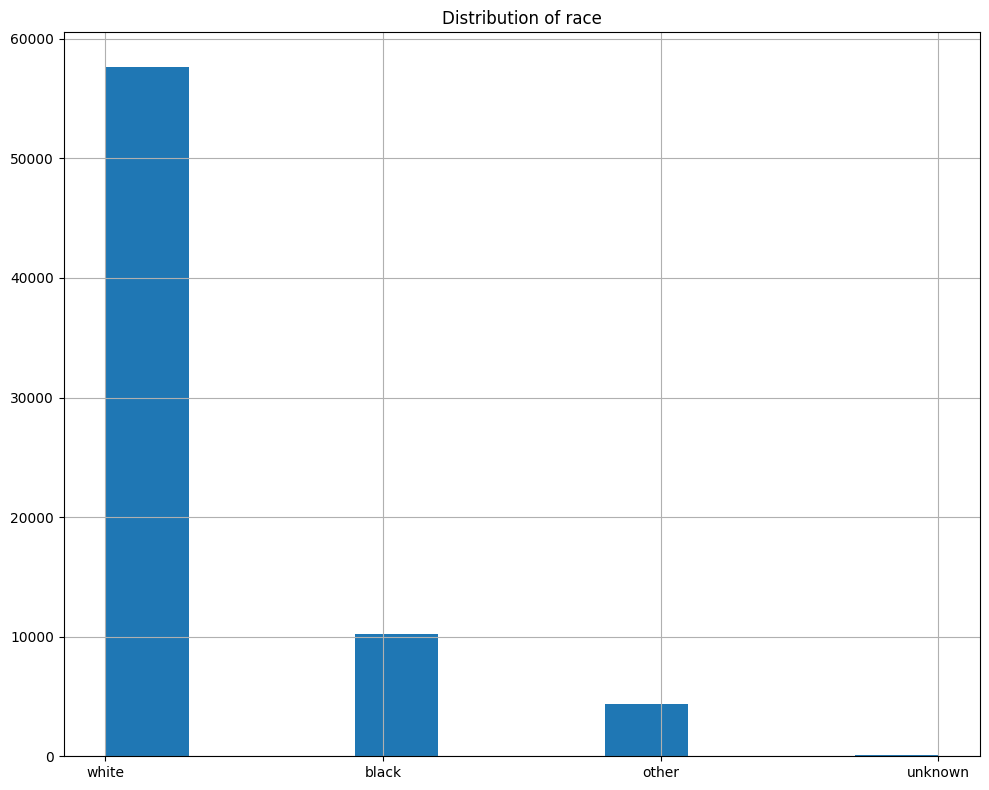

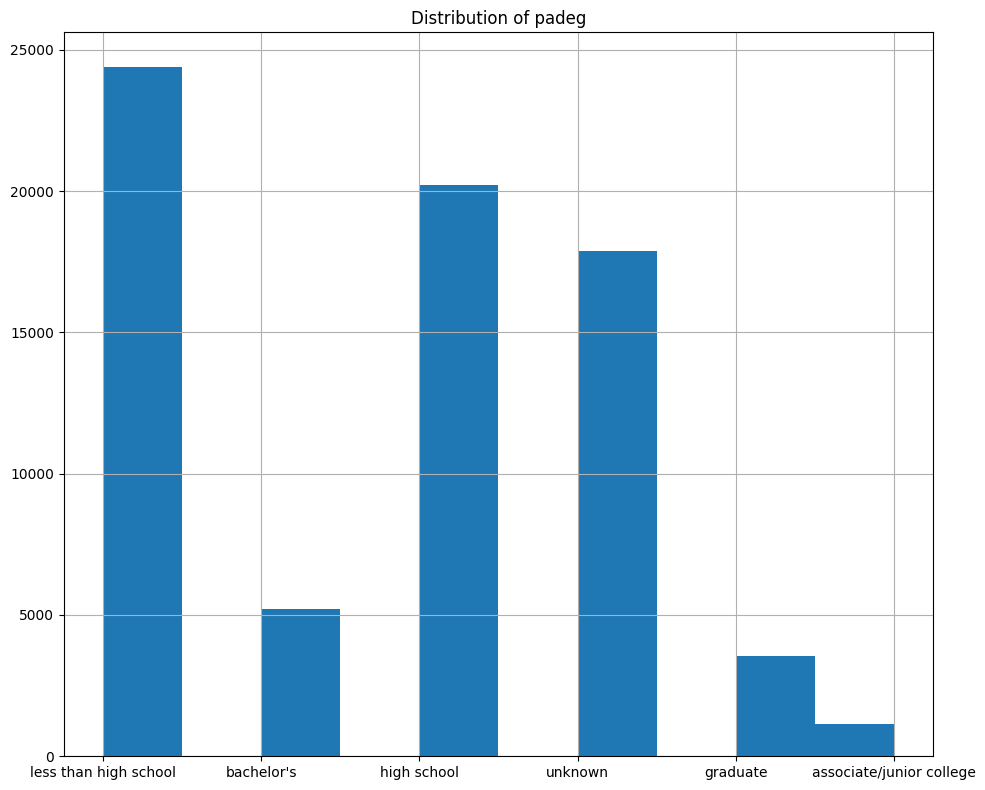

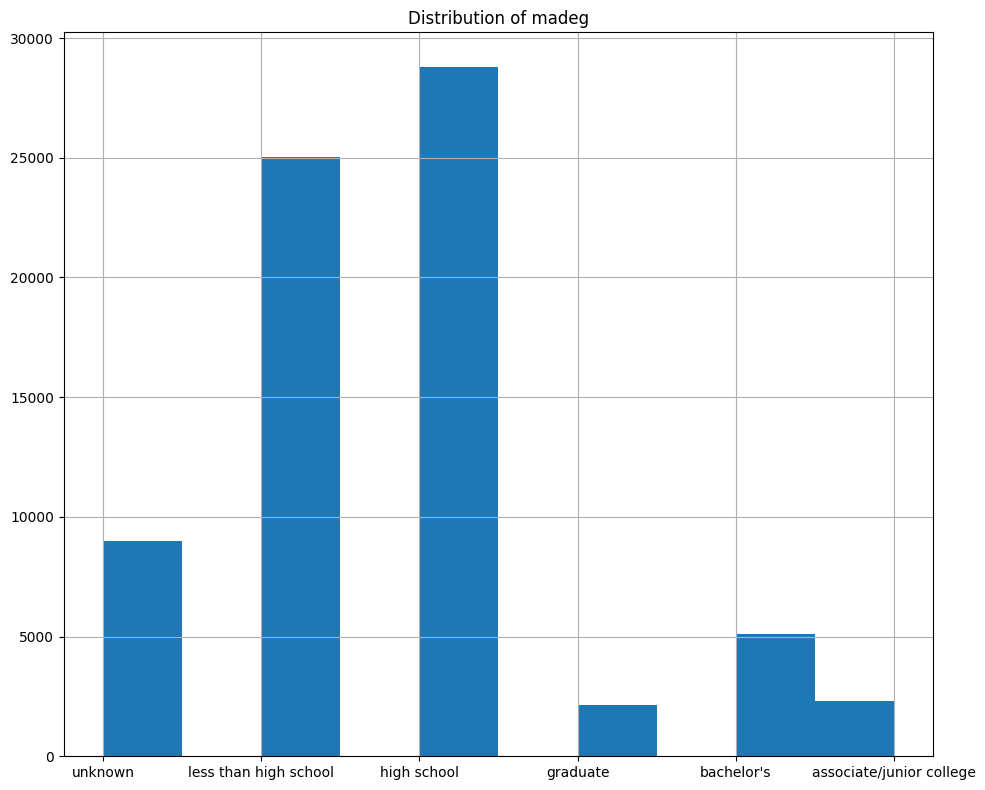

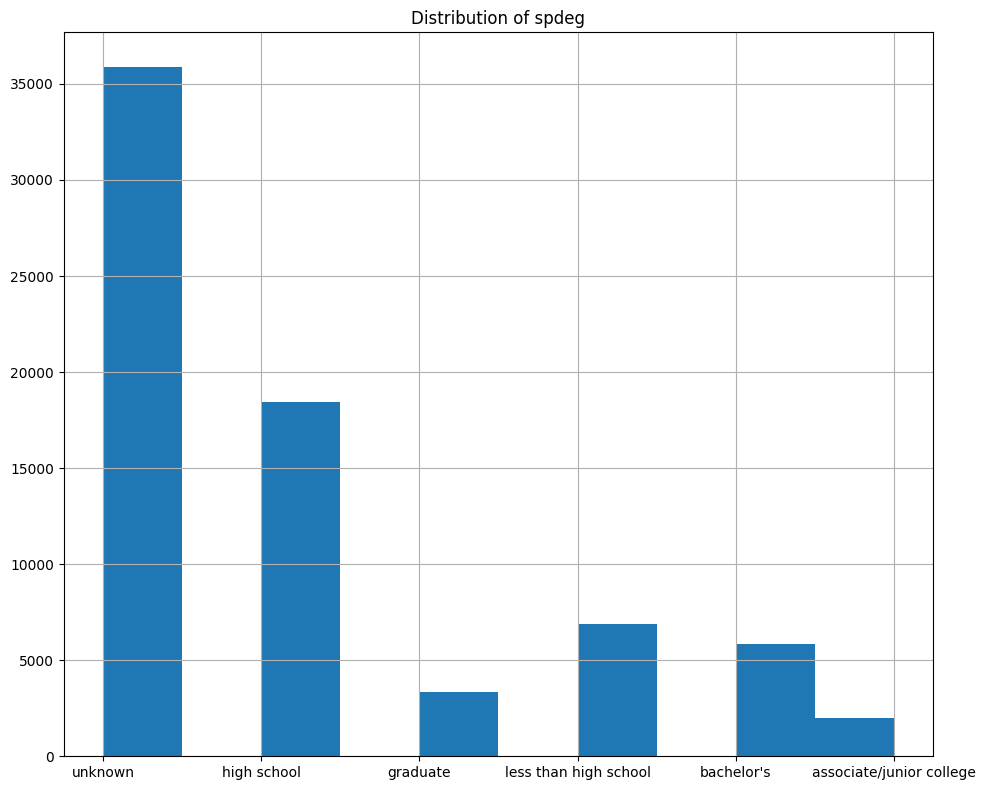

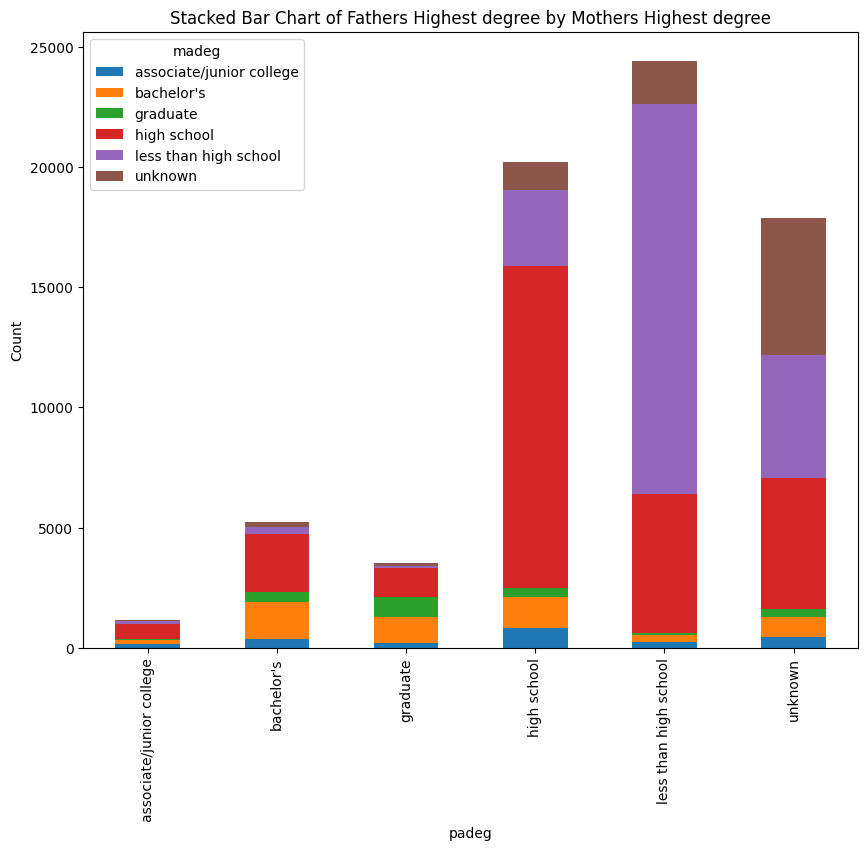

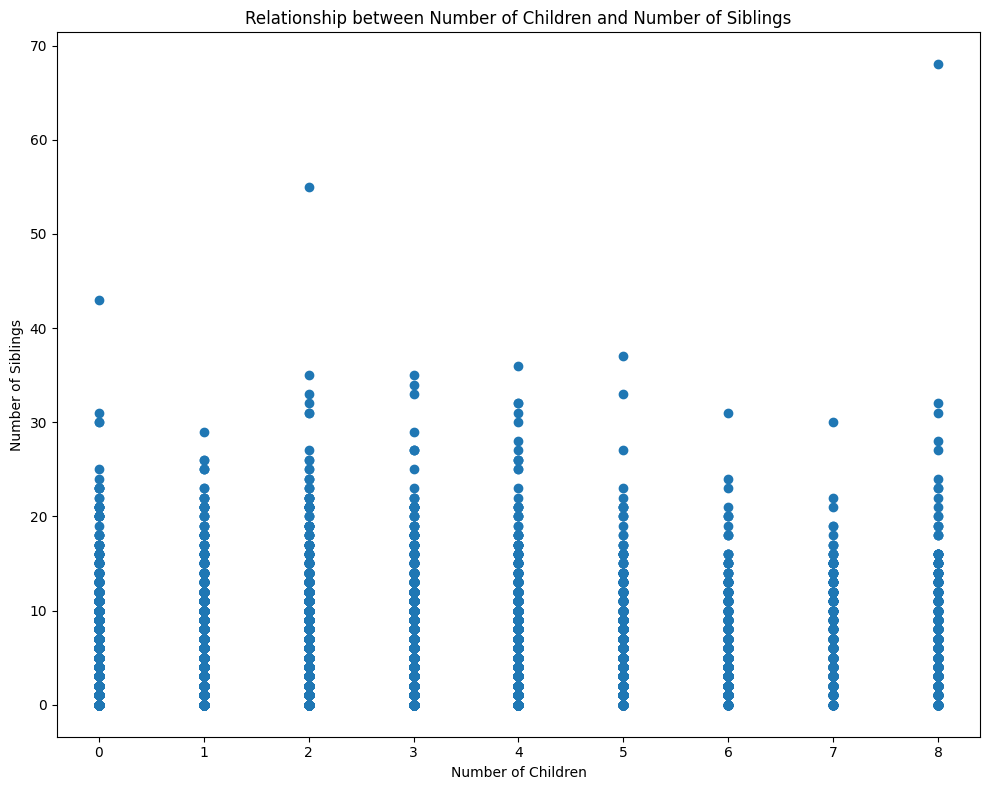

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

#Cleaning the data

#loading data into a dataframe
df = pd.read_csv('selected_gss_data.csv')

#to see what i'm working with, I want to first see how many variables are missing
print("Missing values before cleaning:")
print(df.isnull().sum())

#i see that the rincome variable has all nan values, so I want to drop it
df = df.dropna(axis=1, how='all')

#I now want to identify the different kinds of variables I'm looking at
numerical_cols = ['age', 'childs', 'sibs', 'educ', 'hrs2','year']
categorical_cols = ['race', 'padeg', 'madeg', 'spdeg']

#to clean my quantitative variables, i want to get rid of any non-digit characters and then convert the values to actual numbers instead of strings
#in order to take care of missing values, i'm substituting nans with the median of the data
for numVar in numerical_cols:
  df[numVar] = df[numVar].replace(r'\D', '')
  df[numVar] = pd.to_numeric(df[numVar], errors='coerce')
  #here, i'm replacing any missing values with the median value of the variable, so as to not skew the data substantially
  df[numVar] = df[numVar].fillna(df[numVar].median())

#to clean my qualitative variables, i'm filling all missing values with an "unknown marker", and then I'm standardizing all other options by stripping whitespace and making them all lowercase
for catVar in categorical_cols:
  df[catVar] = df[catVar].fillna('Unknown')
  df[catVar] = df[catVar].astype(str)
  df[catVar] = df[catVar].str.strip()
  df[catVar] = df[catVar].str.lower()
  print("unique values for ",catVar,"after cleaning are: ",df[catVar].unique())

#Numeric summaries

#I want to start off my EDA by looking at descriptive summaries for each variable

#for quantitative variable, i'll just look at mean, median, range, etc.
print(df.describe())

#for categorical variables, i'm going to look at the distribution of each variable over time using histograms
for catVar in categorical_cols:
  plt.figure(figsize=(10, 8))
  df[catVar].hist()
  plt.title(f"Distribution of {catVar}")
  plt.tight_layout()
  plt.show()

#Visualizations

#since my rincome variable didn't have any real data i can use, i want to look at some other relationships in the data

#plotting relationship between mother and father's highest income
crosstab = pd.crosstab(df['padeg'], df['madeg'])
crosstab.plot(kind="bar", stacked=True, figsize=(10, 8))
plt.title('Stacked Bar Chart of Fathers Highest degree by Mothers Highest degree')
plt.ylabel('Count')
plt.show()

#plotting relationship between number of siblings and number of children
plt.figure(figsize=(10, 8))
plt.scatter(df['childs'], df['sibs'])
plt.xlabel('Number of Children')
plt.ylabel("Number of Siblings")
plt.title("Relationship between Number of Children and Number of Siblings")
plt.tight_layout()
plt.show()